# Setup shapefiles, libraries and CuttingGrids

In [ ]:
# Load necessary libraries
import geopandas as gpd

# List of shapefiles to check
shapefiles = {
    'CuttingGrids': '/content/drive/MyDrive/Computerscience student/CuttingGrids.shp',
    'SBNFMortalityt': '/content/drive/MyDrive/Computerscience student/SBNFMortalityt.shp',
    'Communityfeatures': '/content/drive/MyDrive/Computerscience student/Communityfeatures.shp',
    'EgressRoutes': '/content/drive/MyDrive/Computerscience student/EgressRoutes.shp',
    'PopulatedAreast': '/content/drive/MyDrive/Computerscience student/PopulatedAreast.shp',
    'Transmission': '/content/drive/MyDrive/Computerscience student/Transmission.shp',
    'SubTransmission': '/content/drive/MyDrive/Computerscience student/SubTransmission.shp',
    'Substations': '/content/drive/MyDrive/Computerscience student/Substations.shp',
    'DistCircuits': '/content/drive/MyDrive/Computerscience student/DistCircuits.shp',
    'PoleTopSubs': '/content/drive/MyDrive/Computerscience student/PoleTopSubs.shp'
}

# Check the fields of each shapefile
for name, path in shapefiles.items():
    try:
        gdf = gpd.read_file(path)
        print(f"{name} fields: {list(gdf.columns)}")
    except Exception as e:
        print(f"Error loading {name}: {e}")

CuttingGrids fields: ['OBJECTID', 'GRID', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']
SBNFMortalityt fields: ['OBJECTID', 'SHAPE_Leng', 'SHAPE_Area', 'Tot_mortal', 'geometry']
Communityfeatures fields: ['OBJECTID', 'NAME', 'weight', 'geometry']
EgressRoutes fields: ['OBJECTID', 'weight', 'SHAPE_Leng', 'geometry']
PopulatedAreast fields: ['OBJECTID', 'PLACE_NAME', 'POP', 'pop_per_sq', 'area_sqmi', 'Shape_Leng', 'Shape_Area', 'geometry']
Transmission fields: ['OBJECTID', 'CIRCUIT_NO', 'NAME', 'KV', 'STATUS', 'CENTER', 'CIRCUIT', 'MILES', 'weight', 'value1', 'value2', 'SHAPE_Leng', 'geometry']
SubTransmission fields: ['OBJECTID', 'NAME', 'CA', 'Priority', 'SHAPE_Leng', 'geometry']
Substations fields: ['OBJECTID', 'NAME', 'CITY', 'State', 'Priority', 'geometry']
DistCircuits fields: ['OBJECTID', 'SHAPE_Leng', 'geometry']
PoleTopSubs fields: ['OBJECTID', 'NAME', 'SUB_NO', 'CITY', 'State', 'geometry']


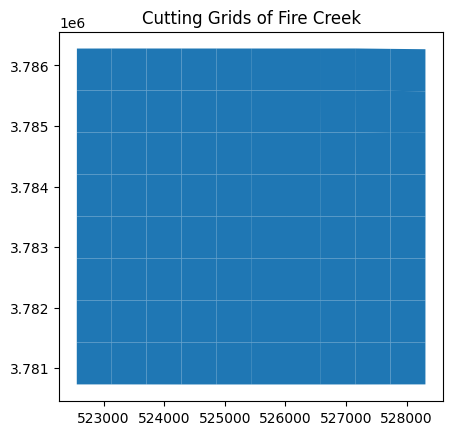

In [ ]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
# Load CuttingGrids shapefile
cutting_grids = gpd.read_file(shapefiles.get('CuttingGrids'))

# Load SBNFMortalityt shapefile

# Visualize the CuttingGrids
cutting_grids.plot()
plt.title('Cutting Grids of Fire Creek')
plt.show()

In [ ]:
cutting_grids.head()

,OBJECTID,GRID,SHAPE_Leng,SHAPE_Area,geometry
0,1,101,2537.837576,399021.521950,"POLYGON ((523133.305 3785584.766, 522557.876 3..."
1,2,102,2539.140326,399427.478483,"POLYGON ((523708.722 3786278.902, 523708.722 3..."
2,3,103,2539.100092,399417.395530,"POLYGON ((524284.151 3786278.872, 524284.151 3..."
3,4,111,2536.942590,398796.532513,"POLYGON ((523133.305 3784891.723, 522557.878 3..."
4,5,112,2536.921970,398789.372624,"POLYGON ((523708.724 3784891.722, 523133.305 3..."


# Analyze Each Factor

## Analyze Tree Mortality

In [ ]:
# Load the tree mortality shapefile (SBNFMortalityt)
tree_mortality = gpd.read_file(shapefiles.get('SBNFMortalityt'))

# Normalize the Tot_mortal to a scale of 1-9
max_mortality = tree_mortality['Tot_mortal'].max()
min_mortality = tree_mortality['Tot_mortal'].min()

def normalize_mortality(mortality):
    if max_mortality == min_mortality:
        return 5
    return int((mortality - min_mortality) / (max_mortality - min_mortality) * 8) + 1

# Apply the normalization function to create the mortality weight column
tree_mortality['weight'] = tree_mortality['Tot_mortal'].apply(normalize_mortality)

# Display the updated dataframe
print(tree_mortality[['OBJECTID', 'Tot_mortal', 'weight']])

    OBJECTID  Tot_mortal  weight
0          1        10.0       1
1          2         5.0       1
2          3        25.0       3
3          4        25.0       3
4          5        75.0       9
5          6        30.0       3
6          7         4.0       1
7          8        50.0       6
8          9        25.0       3
9         10        50.0       6
10        11        50.0       6
11        12         4.0       1


<ipython-input-5-31b05c8fd506>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cutting_grids['mortality_weight'].fillna(0, inplace=True)


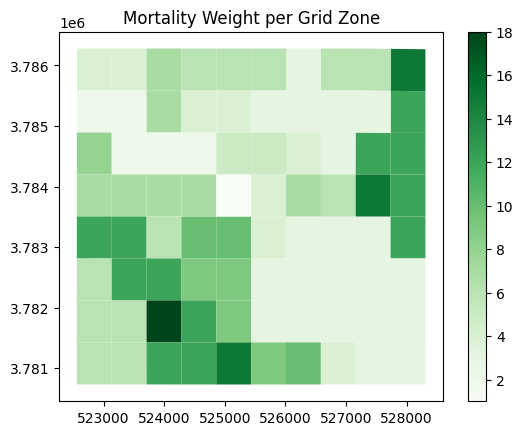

In [ ]:
# Ensure both shapefiles have the same coordinate reference system (CRS)
tree_mortality = tree_mortality.to_crs(cutting_grids.crs)

# Use 'GRID' field as the unique identifier for each grid zone
cutting_grids['GRID'] = cutting_grids['GRID'].astype(str)

# Spatial join: Intersect the tree mortality data with the cutting grids
mortality_in_grids = gpd.sjoin(tree_mortality, cutting_grids, how="inner", predicate="intersects")

# Calculate the total mortality within each grid zone (or use weight if mortality is the weight factor)
mortality_counts = mortality_in_grids.groupby('GRID')['weight'].sum().reset_index(name='mortality_weight')

# Merge the mortality weights back into the cutting grids
cutting_grids = cutting_grids.merge(mortality_counts, on='GRID', how='left')

# Fill NaN values with 0 (in case some zones don't have any mortality data)
cutting_grids['mortality_weight'].fillna(0, inplace=True)

# Visualize the grid with mortality weights
cutting_grids.plot(column='mortality_weight', cmap='Greens', legend=True)
plt.title('Mortality Weight per Grid Zone')
plt.show()

In [ ]:
cutting_grids.head()

,OBJECTID,GRID,SHAPE_Leng,SHAPE_Area,geometry,mortality_weight
0,1,101,2537.837576,399021.521950,"POLYGON ((523133.305 3785584.766, 522557.876 3...",4
1,2,102,2539.140326,399427.478483,"POLYGON ((523708.722 3786278.902, 523708.722 3...",4
2,3,103,2539.100092,399417.395530,"POLYGON ((524284.151 3786278.872, 524284.151 3...",7
3,4,111,2536.942590,398796.532513,"POLYGON ((523133.305 3784891.723, 522557.878 3...",2
4,5,112,2536.921970,398789.372624,"POLYGON ((523708.724 3784891.722, 523133.305 3...",2


## Analyze Populated Areast

In [ ]:
# Load the PopulatedAreast shapefile
populated_areas = gpd.read_file(shapefiles.get('PopulatedAreast'))

# Normalize the pop_per_sq to a scale of 1-9
max_pop_density = populated_areas['pop_per_sq'].max()
min_pop_density = populated_areas['pop_per_sq'].min()

def normalize_weight(pop_density):
    if max_pop_density == min_pop_density:
        return 5
    return int((pop_density - min_pop_density) / (max_pop_density - min_pop_density) * 8) + 1

# Apply the normalization function to create the weight column
populated_areas['weight'] = populated_areas['pop_per_sq'].apply(normalize_weight)

# Display the updated dataframe
print(populated_areas[['PLACE_NAME', 'pop_per_sq', 'weight']])


              PLACE_NAME  pop_per_sq  weight
0  Fire Creek Deep South          89       1
1  Fire Creek North East         550       9
2       Fire Creek South         139       1
3        Fire Creek West         155       2
4        Fire Creek East         472       7
5       Fire Creek North          83       1


<ipython-input-8-372467c5a000>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cutting_grids['population_weight'].fillna(0, inplace=True)


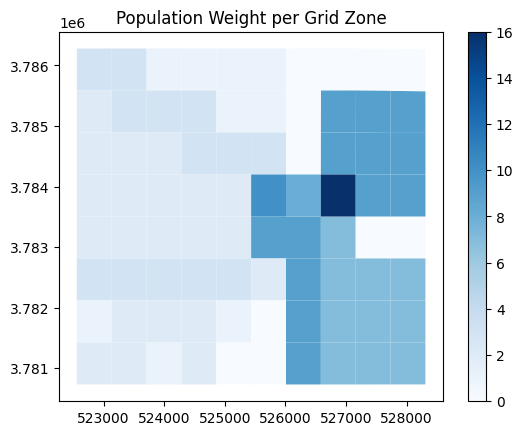

In [ ]:
# Ensure both shapefiles have the same coordinate reference system (CRS)
populated_areas = populated_areas.to_crs(cutting_grids.crs)

# Spatial join: Intersect the populated areas with the cutting grids
populated_in_grids = gpd.sjoin(populated_areas, cutting_grids, how="inner", predicate="intersects")

# Calculate the total population within each grid zone (or use weight if population is the weight factor)
populated_counts = populated_in_grids.groupby('GRID')['weight'].sum().reset_index(name='population_weight')

# Merge the population weights back into the cutting grids
cutting_grids = cutting_grids.merge(populated_counts, on='GRID', how='left')

# Fill NaN values with 0 (in case some zones don't have any population data)
cutting_grids['population_weight'].fillna(0, inplace=True)

# Visualize the grid with population weights
cutting_grids.plot(column='population_weight', cmap='Blues', legend=True)
plt.title('Population Weight per Grid Zone')
plt.show()

In [ ]:
cutting_grids.head()

,OBJECTID,GRID,SHAPE_Leng,SHAPE_Area,geometry,mortality_weight,population_weight
0,1,101,2537.837576,399021.521950,"POLYGON ((523133.305 3785584.766, 522557.876 3...",4,3.0
1,2,102,2539.140326,399427.478483,"POLYGON ((523708.722 3786278.902, 523708.722 3...",4,3.0
2,3,103,2539.100092,399417.395530,"POLYGON ((524284.151 3786278.872, 524284.151 3...",7,1.0
3,4,111,2536.942590,398796.532513,"POLYGON ((523133.305 3784891.723, 522557.878 3...",2,2.0
4,5,112,2536.921970,398789.372624,"POLYGON ((523708.724 3784891.722, 523133.305 3...",2,3.0


## Analyze Community Features

<ipython-input-10-7c6355c00035>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cutting_grids['weight_community'].fillna(0, inplace=True)


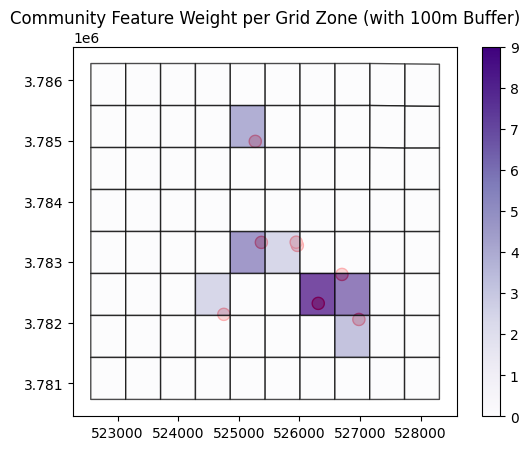

In [ ]:
# Load the Communityfeatures shapefile
community_features = gpd.read_file(shapefiles.get('Communityfeatures'))

# Ensure both shapefiles have the same CRS
community_features = community_features.to_crs(cutting_grids.crs)

# Create a 100m buffer around each community feature
community_features['buffer'] = community_features.geometry.buffer(100)

# Perform spatial join to find intersecting grids
joined = gpd.sjoin(cutting_grids, community_features, how='left', predicate='intersects')

# Sum the weights of the community features for each grid
weight_community = joined.groupby('GRID')['weight'].sum().reset_index()

# Rename the column for clarity
weight_community.rename(columns={'weight': 'weight_community'}, inplace=True)

# Merge the weights back into the cutting grids
cutting_grids = cutting_grids.merge(weight_community, on='GRID', how='left')

# Fill NaN values with 0
cutting_grids['weight_community'].fillna(0, inplace=True)

# Visualize the grid with community feature weights
fig, ax = plt.subplots()
community_features['buffer'].plot(color='lightcoral', ax=ax, label='community_features Buffer (100m)', edgecolor='red')
cutting_grids.plot(column='weight_community', cmap='Purples', legend=True, ax=ax, edgecolor='black', alpha=0.7)
plt.title('Community Feature Weight per Grid Zone (with 100m Buffer)')
plt.show()

In [ ]:
cutting_grids.head()

,OBJECTID,GRID,SHAPE_Leng,SHAPE_Area,geometry,mortality_weight,population_weight,weight_community
0,1,101,2537.837576,399021.521950,"POLYGON ((523133.305 3785584.766, 522557.876 3...",4,3.0,0.0
1,2,102,2539.140326,399427.478483,"POLYGON ((523708.722 3786278.902, 523708.722 3...",4,3.0,0.0
2,3,103,2539.100092,399417.395530,"POLYGON ((524284.151 3786278.872, 524284.151 3...",7,1.0,0.0
3,4,111,2536.942590,398796.532513,"POLYGON ((523133.305 3784891.723, 522557.878 3...",2,2.0,0.0
4,5,112,2536.921970,398789.372624,"POLYGON ((523708.724 3784891.722, 523133.305 3...",2,3.0,0.0


## Analyze Egress Routes

<ipython-input-12-dba109e66fd5>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cutting_grids['weight_egress'].fillna(0, inplace=True)


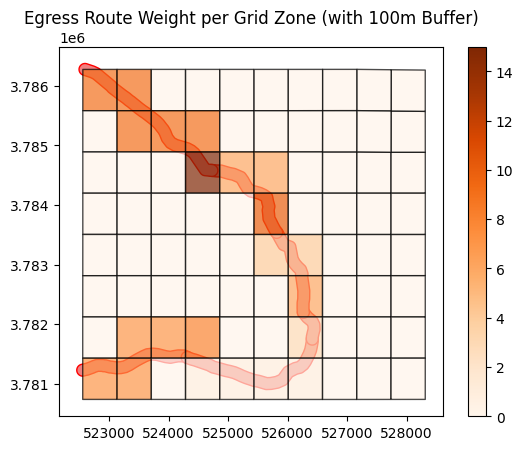

In [ ]:
# Load the EgressRoutes shapefile
egress_routes = gpd.read_file(shapefiles.get('EgressRoutes'))

# Ensure both shapefiles have the same CRS
egress_routes = egress_routes.to_crs(cutting_grids.crs)

# Create a 100m buffer around each egress route
egress_routes['buffer'] = egress_routes.geometry.buffer(100)

# Perform spatial join to find intersecting grids
joined_egress = gpd.sjoin(cutting_grids, egress_routes, how='left', predicate='intersects')

# Sum the weights of the egress routes for each grid
weight_egress = joined_egress.groupby('GRID')['weight'].sum().reset_index()

# Rename the column for clarity
weight_egress.rename(columns={'weight': 'weight_egress'}, inplace=True)

# Merge the weights back into the cutting grids
cutting_grids = cutting_grids.merge(weight_egress, on='GRID', how='left')

# Fill NaN values with 0
cutting_grids['weight_egress'].fillna(0, inplace=True)

# Visualize the grid with egress route weights
fig, ax = plt.subplots()
egress_routes['buffer'].plot(color='lightcoral', ax=ax, label='Egress Route Buffer (100m)', edgecolor='red')
cutting_grids.plot(column='weight_egress', cmap='Oranges', legend=True, ax=ax, edgecolor='black', alpha=0.7)
plt.title('Egress Route Weight per Grid Zone (with 100m Buffer)')
plt.show()

In [ ]:
cutting_grids.head()

,OBJECTID,GRID,SHAPE_Leng,SHAPE_Area,geometry,mortality_weight,population_weight,weight_community,weight_egress
0,1,101,2537.837576,399021.521950,"POLYGON ((523133.305 3785584.766, 522557.876 3...",4,3.0,0.0,9.0
1,2,102,2539.140326,399427.478483,"POLYGON ((523708.722 3786278.902, 523708.722 3...",4,3.0,0.0,9.0
2,3,103,2539.100092,399417.395530,"POLYGON ((524284.151 3786278.872, 524284.151 3...",7,1.0,0.0,0.0
3,4,111,2536.942590,398796.532513,"POLYGON ((523133.305 3784891.723, 522557.878 3...",2,2.0,0.0,0.0
4,5,112,2536.921970,398789.372624,"POLYGON ((523708.724 3784891.722, 523133.305 3...",2,3.0,0.0,9.0


In [ ]:
# Define external weights for each factor
external_weight_mortality = 0.4
external_weight_population = 0.3
external_weight_community = 0.2
external_weight_egress = 0.1

# Apply external weights to each utility factor
cutting_grids['weighted_mortality'] = cutting_grids['mortality_weight'] * external_weight_mortality
cutting_grids['weighted_population'] = cutting_grids['population_weight'] * external_weight_population
cutting_grids['weighted_community'] = cutting_grids['weight_community'] * external_weight_community
cutting_grids['weighted_egress'] = cutting_grids['weight_egress'] * external_weight_egress

# Calculate the total weighted utility score for each grid zone
cutting_grids['total_weighted_score'] = (
    cutting_grids['weighted_mortality'] +
    cutting_grids['weighted_population'] +
    cutting_grids['weighted_community'] +
    cutting_grids['weighted_egress']
)

# Display the updated dataframe with total weighted scores
print(cutting_grids[['GRID', 'weighted_mortality', 'weighted_population', 'weighted_community', 'weighted_egress', 'total_weighted_score']])

   GRID  weighted_mortality  weighted_population  weighted_community  \
0   101                 1.6                  0.9                 0.0   
1   102                 1.6                  0.9                 0.0   
2   103                 2.8                  0.3                 0.0   
3   111                 0.8                  0.6                 0.0   
4   112                 0.8                  0.9                 0.0   
..  ...                 ...                  ...                 ...   
75  110                 6.0                  0.0                 0.0   
76  108                 2.4                  0.0                 0.0   
77  109                 2.4                  0.0                 0.0   
78  118                 1.2                  2.7                 0.0   
79  119                 1.2                  2.7                 0.0   

    weighted_egress  total_weighted_score  
0               0.9                   3.4  
1               0.9                   3.4  
2  

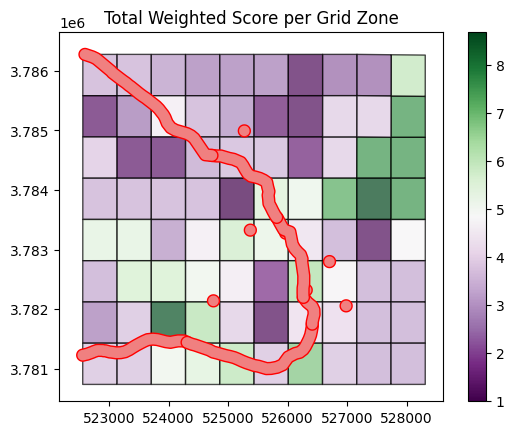

In [ ]:
# Total Weighted Score Visualization
fig, ax = plt.subplots()
cutting_grids.plot(column='total_weighted_score', cmap='PRGn', legend=True, ax=ax, edgecolor='black', alpha=0.7)
community_features['buffer'].plot(color='lightcoral', ax=ax, label='community_features Buffer (100m)', edgecolor='red')
egress_routes['buffer'].plot(color='lightcoral', ax=ax, label='Egress Route Buffer (100m)', edgecolor='red')

plt.title('Total Weighted Score per Grid Zone')
plt.show()


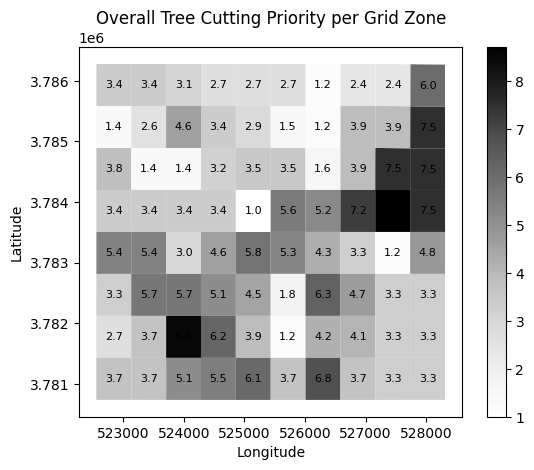

In [ ]:
# Round the values in the 'overall_priority' column to a single decimal place for better readability
cutting_grids['total_weighted_score'] = cutting_grids['total_weighted_score'].round(1)

# Plot the grid with overall priority weights and rounded labels
fig, ax = plt.subplots(1, 1)
cutting_grids.plot(column='total_weighted_score', cmap='Greys', legend=True, ax=ax)

# Add labels to the grid cells with rounded values
for idx, row in cutting_grids.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, round(row['total_weighted_score'], 1),
             fontsize=8, ha='center', va='center')

# Set titles and labels
plt.title('Overall Tree Cutting Priority per Grid Zone')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()